# Signed Directed Bitcoin OTC web of trust network

### Dataset information:
This is who-trusts-whom network of people who trade using Bitcoin on a platform called Bitcoin OTC. Since Bitcoin users are anonymous, there is a need to maintain a record of users' reputation to prevent transactions with fraudulent and risky users. Members of Bitcoin OTC rate other members in a scale of -10 (total distrust) to +10 (total trust) in steps of 1. This is the first explicit weighted signed directed network available for research.

<img src="data/image.png" alt="Drawing" style="width: 350px;"/>

Each line has one rating, sorted by time with the following format: 
    `SOURCE, TARGET, RATING, TIME`

Some draws of the network from GEPHI:
<img src="output/gephi_draws/screenshot_121233.png" alt="Drawing" style="width: 650px;"/>
<img src="output/gephi_draws/screenshot_121958.png" alt="Drawing" style="width: 650px;"/>

### Read data and build network using NetworkX

In [1]:
# imports
import collections

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx

from data_tools import plot_functions as func

%matplotlib notebook

In [2]:
# read file
register_matplotlib_converters()
data = pd.read_csv('data/soc-sign-bitcoinotc.csv', sep=',', decimal='.', parse_dates=True, infer_datetime_format=True)
# time is in epochtime format, can be transformed to date time
data.head()

,Source,Target,Rating,Time
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09


In [3]:
# create the graph
graph = nx.from_pandas_edgelist(data, source='Source', target='Target', edge_attr='Rating', create_using=nx.DiGraph)
n_nodes = graph.number_of_nodes()
n_edges = graph.number_of_edges()

# Network properties

In [4]:
# Table to store stats for each node.
stats = pd.DataFrame(graph.nodes()) 
stats.columns = ['Node']
#stats.head()

### Number of nodes and edges

In [5]:
print("Number of nodes:", n_nodes)
print("Number of edges:", n_edges)

Number of nodes: 5881
Number of edges: 35592


### Edge weights (ratings) frequency and distribution

In [6]:
counts = data.groupby(['Rating']).size().reset_index(name='Frequency')
counts['Probability'] = counts['Frequency'] / counts['Frequency'].sum()
counts

,Rating,Frequency,Probability
0,-10,2413,0.067796
1,-9,20,0.000562
2,-8,31,0.000871
3,-7,14,0.000393
4,-6,5,0.000140
5,-5,179,0.005029
6,-4,27,0.000759
7,-3,91,0.002557
8,-2,182,0.005114
9,-1,601,0.016886


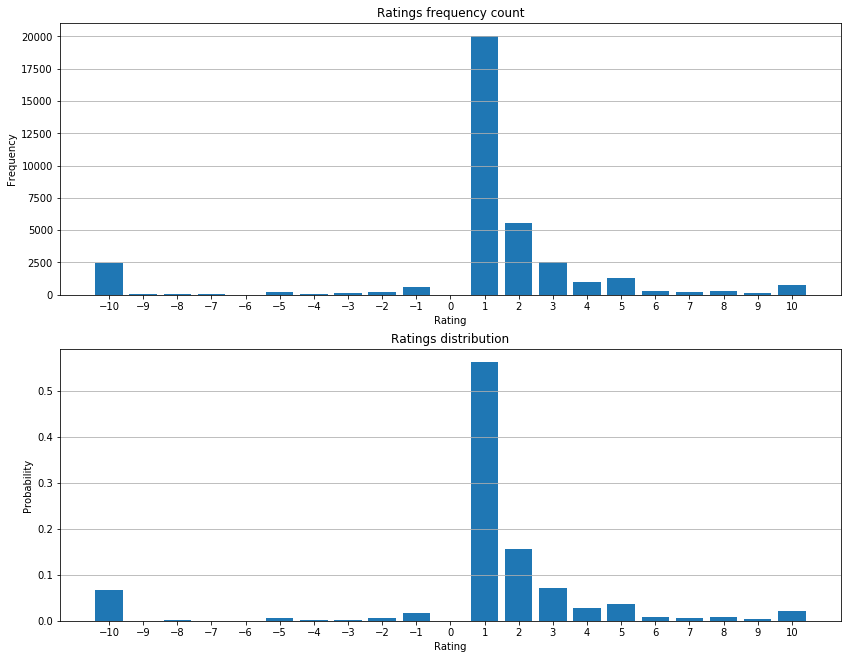

In [7]:
fig = plt.figure()
fig.set_size_inches(14.0, 11.0)

bins = np.linspace(-10,10,21)

# Ratings frequency (count for each rating).
ax = plt.subplot(2, 1, 1)

plt.bar(counts['Rating'], counts['Frequency'])

plt.title('Ratings frequency count')
plt.xlabel('Rating')
plt.ylabel('Frequency')

ax.xaxis.set_ticks(bins)

plt.grid(True, axis='y')

# Ratings probability (distribution).
ax = plt.subplot(2, 1, 2)

plt.bar(counts['Rating'], counts['Probability'])

plt.title('Ratings distribution')
plt.xlabel('Rating')
plt.ylabel('Probability')

ax.xaxis.set_ticks(bins)

plt.grid(True, axis='y')

#fig.savefig("output/ratings_frequency.pdf")

plt.show()

### Degree centrality

In [8]:
# convert dictionary into list of tuples
degree_list = [v for k, v in nx.degree_centrality(graph).items()] 
in_degree_list = [v for k, v in nx.in_degree_centrality(graph).items()] 
out_degree_list = [v for k, v in nx.out_degree_centrality(graph).items()] 

# Store node degree centrality (considering graph as unirected)
stats['Degree'] = degree_list

# Store node in-degree centrality (considering graph as directed)
stats['InDegree'] = in_degree_list

# Store node out-degree centrality (considering graph as directed)
stats['OutDegree'] = out_degree_list

# Transform normalized (%) to absolute value.
stats['Degree'] = round(stats['Degree'] * (n_nodes-1))
stats['InDegree'] = round(stats['InDegree']  * (n_nodes-1))                
stats['OutDegree'] = round(stats['OutDegree'] * (n_nodes-1))

#### Top 10 nodes with highest degree Centrality

In [9]:
stats.sort_values(by='Degree', ascending=False).head(10)

,Node,Degree,InDegree,OutDegree
26,35,1298.0,535.0,763.0
2587,2642,818.0,412.0,406.0
1764,1810,715.0,311.0,404.0
2077,2125,577.0,180.0,397.0
1981,2028,572.0,279.0,293.0
864,905,528.0,264.0,264.0
4092,4172,486.0,222.0,264.0
6,7,448.0,216.0,232.0
0,1,441.0,226.0,215.0
4115,4197,405.0,203.0,202.0


#### Top 10 nodes with highest in-degree centrality

In [10]:
stats.sort_values(by='InDegree', ascending=False).head(10)

,Node,Degree,InDegree,OutDegree
26,35,1298.0,535.0,763.0
2587,2642,818.0,412.0,406.0
1764,1810,715.0,311.0,404.0
1981,2028,572.0,279.0,293.0
864,905,528.0,264.0,264.0
0,1,441.0,226.0,215.0
4092,4172,486.0,222.0,264.0
6,7,448.0,216.0,232.0
4115,4197,405.0,203.0,202.0
10,13,401.0,191.0,210.0


#### Top 10 nodes with highest out-degree centrality

In [11]:
stats.sort_values(by='OutDegree', ascending=False).head(10)

,Node,Degree,InDegree,OutDegree
26,35,1298.0,535.0,763.0
2587,2642,818.0,412.0,406.0
1764,1810,715.0,311.0,404.0
2077,2125,577.0,180.0,397.0
1981,2028,572.0,279.0,293.0
864,905,528.0,264.0,264.0
4092,4172,486.0,222.0,264.0
6,7,448.0,216.0,232.0
0,1,441.0,226.0,215.0
3062,3129,229.0,17.0,212.0


### Degree distribution

In [51]:
counts = stats.groupby(['Degree']).size().reset_index(name='Frequency')
counts['Probability'] = counts['Frequency'] / counts['Frequency'].sum()
counts.head(10)

,Degree,Frequency,Probability
0,1.0,829,0.140962
1,2.0,1622,0.275803
2,3.0,380,0.064615
3,4.0,621,0.105594
4,5.0,259,0.044040
5,6.0,324,0.055093
6,7.0,153,0.026016
7,8.0,185,0.031457
8,9.0,112,0.019044
9,10.0,139,0.023635


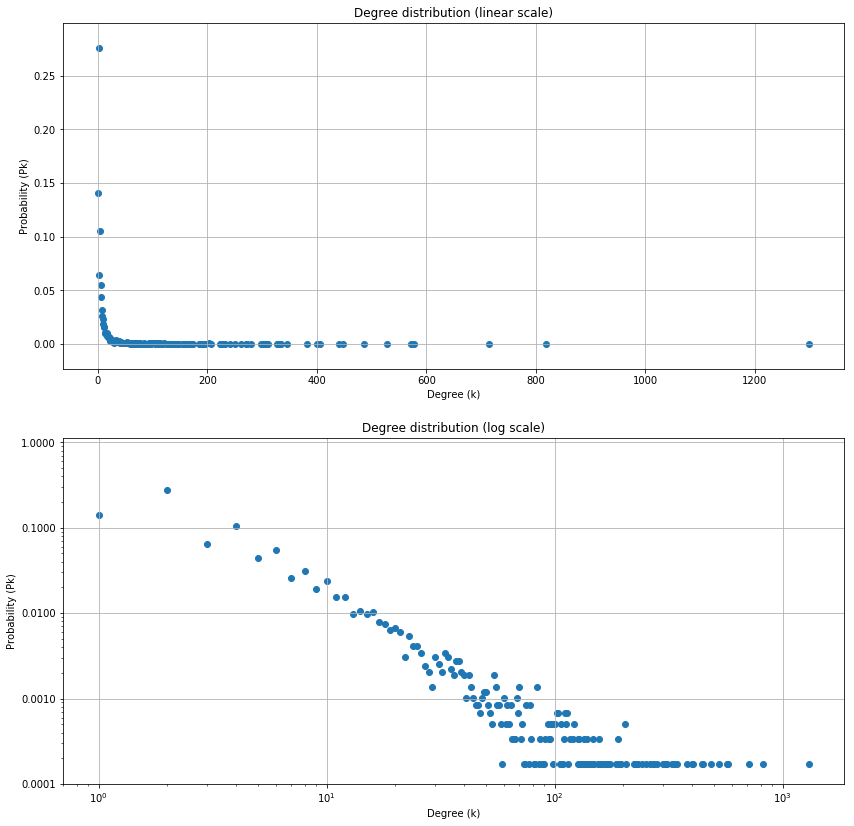

In [53]:
fig = plt.figure()
fig.set_size_inches(14.0, 14.0)

# Linear scale.
ax = plt.subplot(2, 1, 1)

plt.scatter(counts['Degree'], counts['Probability'])

plt.title('Degree distribution (linear scale)')
plt.xlabel('Degree (k)')
plt.ylabel('Probability (Pk)')

plt.grid()

# Log scale.
ax = plt.subplot(2, 1, 2)

plt.scatter(counts['Degree'], counts['Probability'])

plt.title('Degree distribution (log scale)')
plt.xlabel('Degree (k)')
plt.ylabel('Probability (Pk)')

ax.set_xscale('log')

# This is the only way I found to make it work. Matplotlib log scale only works for positive values.
# Can't make symlog scale to work either.
ax.set_yscale('log')
ticks = [1,1e-01, 1e-02, 1e-03, 1e-04]
ax.set_yticks(ticks)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.set_yticklabels([str(t) for t in ticks])
plt.grid()

fig.savefig("output/degree_distribution.pdf")

plt.show()

### Weighted degree centrality

In [12]:
# convert dictionary into list of tuples
weighted_degree_list = [v for k, v in graph.degree(weight='Rating')] 
weighted_in_degree_list = [v for k, v in graph.in_degree(weight='Rating')] 
weighted_out_degree_list = [v for k, v in graph.out_degree(weight='Rating')] 

# Store node degree centrality (considering graph as unirected)
stats['WeightedDegree'] = weighted_degree_list

# Store node in-degree centrality (considering graph as directed)
stats['WeightedInDegree'] = weighted_in_degree_list

# Store node out-degree centrality (considering graph as directed)
stats['WeightedOutDegree'] = weighted_out_degree_list

#### Top 10 nodes with highest weighted degree centrality

In [13]:
stats.sort_values(by='WeightedDegree', ascending=False).head(10)

,Node,Degree,InDegree,OutDegree,WeightedDegree,WeightedInDegree,WeightedOutDegree
26,35,1298.0,535.0,763.0,1890,1016,874
2587,2642,818.0,412.0,406.0,1805,1041,764
0,1,441.0,226.0,215.0,1234,801,433
6,7,448.0,216.0,232.0,1125,614,511
977,1018,382.0,179.0,203.0,775,471,304
4206,4291,330.0,158.0,172.0,697,360,337
4115,4197,405.0,203.0,202.0,677,416,261
10,13,401.0,191.0,210.0,627,341,286
1981,2028,572.0,279.0,293.0,578,202,376
1354,1396,280.0,118.0,162.0,518,237,281


#### Top 10 nodes with lowest weighted degree centrality

In [14]:
stats.sort_values(by='WeightedDegree').head(10)

,Node,Degree,InDegree,OutDegree,WeightedDegree,WeightedInDegree,WeightedOutDegree
1764,1810,715.0,311.0,404.0,-706,230,-936
3668,3744,113.0,81.0,32.0,-595,-675,80
2077,2125,577.0,180.0,397.0,-560,439,-999
2218,2266,194.0,53.0,141.0,-508,26,-534
2635,2691,45.0,4.0,41.0,-373,4,-377
3713,3789,35.0,6.0,29.0,-350,-60,-290
2302,2351,48.0,4.0,44.0,-342,6,-348
3710,3786,34.0,6.0,28.0,-340,-60,-280
3714,3790,34.0,6.0,28.0,-340,-60,-280
3715,3791,34.0,6.0,28.0,-340,-60,-280


#### Top 10 nodes with highest weighted in-degree centrality

In [15]:
stats.sort_values(by='WeightedInDegree', ascending=False).head(10)

,Node,Degree,InDegree,OutDegree,WeightedDegree,WeightedInDegree,WeightedOutDegree
2587,2642,818.0,412.0,406.0,1805,1041,764
26,35,1298.0,535.0,763.0,1890,1016,874
0,1,441.0,226.0,215.0,1234,801,433
6,7,448.0,216.0,232.0,1125,614,511
4092,4172,486.0,222.0,264.0,255,472,-217
977,1018,382.0,179.0,203.0,775,471,304
2077,2125,577.0,180.0,397.0,-560,439,-999
4115,4197,405.0,203.0,202.0,677,416,261
4206,4291,330.0,158.0,172.0,697,360,337
10,13,401.0,191.0,210.0,627,341,286


#### Top 10 nodes with lowest weighted in-degree centrality

In [16]:
stats.sort_values(by='WeightedInDegree').head(10)

,Node,Degree,InDegree,OutDegree,WeightedDegree,WeightedInDegree,WeightedOutDegree
3668,3744,113.0,81.0,32.0,-595,-675,80
2446,2498,45.0,45.0,0.0,-256,-256,0
1341,1383,162.0,96.0,66.0,-46,-232,186
4443,4531,47.0,25.0,22.0,-238,-230,-8
1970,2017,54.0,45.0,9.0,-214,-229,15
4564,4654,46.0,25.0,21.0,-233,-186,-47
4654,4744,21.0,19.0,2.0,-199,-179,-20
4591,4681,39.0,22.0,17.0,-223,-176,-47
4582,4672,30.0,18.0,12.0,-256,-169,-87
4596,4686,38.0,25.0,13.0,-242,-167,-75


#### Top 10 nodes with highest weighted out-degree centrality

In [17]:
stats.sort_values(by='WeightedOutDegree', ascending=False).head(10)

,Node,Degree,InDegree,OutDegree,WeightedDegree,WeightedInDegree,WeightedOutDegree
26,35,1298.0,535.0,763.0,1890,1016,874
2587,2642,818.0,412.0,406.0,1805,1041,764
6,7,448.0,216.0,232.0,1125,614,511
0,1,441.0,226.0,215.0,1234,801,433
217,257,111.0,18.0,93.0,477,57,420
1981,2028,572.0,279.0,293.0,578,202,376
4206,4291,330.0,158.0,172.0,697,360,337
977,1018,382.0,179.0,203.0,775,471,304
10,13,401.0,191.0,210.0,627,341,286
1354,1396,280.0,118.0,162.0,518,237,281


#### Top 10 nodes with lowest weighted out-degree centrality

In [18]:
stats.sort_values(by='WeightedOutDegree').head(10)

,Node,Degree,InDegree,OutDegree,WeightedDegree,WeightedInDegree,WeightedOutDegree
2077,2125,577.0,180.0,397.0,-560,439,-999
1764,1810,715.0,311.0,404.0,-706,230,-936
2218,2266,194.0,53.0,141.0,-508,26,-534
2020,2067,303.0,117.0,186.0,-267,197,-464
2635,2691,45.0,4.0,41.0,-373,4,-377
2302,2351,48.0,4.0,44.0,-342,6,-348
2876,2934,126.0,48.0,78.0,-174,128,-302
4372,4458,49.0,9.0,40.0,-335,-35,-300
3713,3789,35.0,6.0,29.0,-350,-60,-290
3714,3790,34.0,6.0,28.0,-340,-60,-280


## TODO: ADD PLOTS OF WEIGHTED DEGREE DISTRIBUTIONS HERE

### Average node rating

In [29]:
 # count weighted degree distribution
weighted_in_degree = dict()
weighted_out_degree = dict()
for instance in data.values:
    weighted_in_degree[instance[1]] = weighted_in_degree.get(instance[1], 0) + instance[2]
    weighted_in_degree[instance[0]] = weighted_in_degree.get(instance[0], 0)
    weighted_out_degree[instance[0]] = weighted_out_degree.get(instance[0], 0) + instance[2]
    weighted_out_degree[instance[1]] = weighted_out_degree.get(instance[1], 0)
        
in_degree_list_weight = list()

for key, value in weighted_in_degree.items():
    #third value is average value of ratings that node received from other nodes
    if graph.in_degree[key] != 0:
        in_degree_list_weight.append((int(key), value / graph.in_degree[key]))
    else:
        in_degree_list_weight.append((int(key), 0))

out_degree_list_weight = list()
for key, value in weighted_out_degree.items():
    #third value is average value of ratings that node gave to other nodes
    if graph.out_degree[key] != 0:
        out_degree_list_weight.append((int(key), value / graph.out_degree[key]))
    else:
        out_degree_list_weight.append((int(key), 0))

stats['inAvgRating'] = [round(v,2) for k, v in sorted(in_degree_list_weight, key=lambda tup: tup[0])]
stats['outAvgRating'] = [round(v,2) for k, v in sorted(out_degree_list_weight, key=lambda tup: tup[0])]

stats.head(10)

,Node,Degree,InDegree,OutDegree,WeightedDegree,WeightedInDegree,WeightedOutDegree,inAvgRating,outAvgRating
0,1,441.0,226.0,215.0,1234,801,433,3.54,2.01
1,2,86.0,41.0,45.0,266,123,143,3.00,3.18
2,3,21.0,21.0,0.0,-6,-6,0,-0.29,0.00
3,4,117.0,54.0,63.0,343,168,175,3.11,2.78
4,5,6.0,3.0,3.0,14,7,7,2.33,2.33
5,6,84.0,44.0,40.0,158,61,97,1.39,2.42
6,7,448.0,216.0,232.0,1125,614,511,2.84,2.20
7,8,4.0,3.0,1.0,20,17,3,5.67,3.00
8,9,2.0,1.0,1.0,12,2,10,2.00,10.00
9,10,13.0,5.0,8.0,86,30,56,6.00,7.00


### Stats summary

In [30]:
stats_description = stats.describe().drop('Node', axis=1)
stats_description

,Degree,InDegree,OutDegree,WeightedDegree,WeightedInDegree,WeightedOutDegree,inAvgRating,outAvgRating
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,12.104064,6.052032,6.052032,12.249617,6.124809,6.124809,0.725761,1.345783
std,38.298915,17.675082,21.088387,66.453676,38.843600,38.521048,2.821867,2.208497
min,1.000000,0.000000,0.000000,-706.000000,-675.000000,-999.000000,-10.000000,-10.000000
25%,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.690000
50%,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,1.000000
75%,9.000000,5.000000,4.000000,12.000000,6.000000,7.000000,1.690000,2.000000
max,1298.000000,535.000000,763.000000,1890.000000,1041.000000,874.000000,10.000000,10.000000


In [26]:
# convert dictionary into list of tuples
in_degree_list = [(k, v) for k, v in nx.in_degree_centrality(graph).items()] 
out_degree_list = [(k, v) for k, v in nx.out_degree_centrality(graph).items()] 
# sort list of tuples using as key degree
in_degree_list = sorted(in_degree_list, key=lambda tup: tup[1], reverse=True)
out_degree_list = sorted(out_degree_list, key=lambda tup: tup[1], reverse=True)

print("IN-DEGREE CENTRALITY:\n")

print("Fractional degree (%):")
print("20 NODE WITH HIGHEST IN DEGREE \t\t\t20 NODE WITH HIGHEST OUT DEGREE\n")
for i in range(20):
    print("Node:\033[1m", in_degree_list[i][0], "\033[0m\tdegree:\033[1m", in_degree_list[i][1], "\033[0m\tNode:\033[1m" , out_degree_list[i][0], "\033[0m\tdegree:\033[1m", out_degree_list[i][1], "\033[0m")
    
print("\nAbsolute degree:")
print("20 NODE WITH HIGHEST IN DEGREE \t\t\t20 NODE WITH HIGHEST OUT DEGREE\n")
for i in range(20):
    print("Node:\033[1m", in_degree_list[i][0], "\033[0m\tdegree:\033[1m", round(in_degree_list[i][1]*(n_nodes-1)), "\033[0m\tNode:\033[1m" , out_degree_list[i][0], "\033[0m\tdegree:\033[1m", out_degree_list[i][1]*(n_nodes-1), "\033[0m")

IN-DEGREE CENTRALITY:

Fractional degree (%):
20 NODE WITH HIGHEST IN DEGREE 			20 NODE WITH HIGHEST OUT DEGREE

Node: 35 	degree: 0.09098639455782312 	Node: 35 	degree: 0.12976190476190474 
Node: 2642 	degree: 0.07006802721088434 	Node: 2642 	degree: 0.06904761904761904 
Node: 1810 	degree: 0.05289115646258503 	Node: 1810 	degree: 0.06870748299319727 
Node: 2028 	degree: 0.047448979591836735 	Node: 2125 	degree: 0.06751700680272109 
Node: 905 	degree: 0.044897959183673466 	Node: 2028 	degree: 0.049829931972789114 
Node: 1 	degree: 0.03843537414965986 	Node: 905 	degree: 0.044897959183673466 
Node: 4172 	degree: 0.03775510204081632 	Node: 4172 	degree: 0.044897959183673466 
Node: 7 	degree: 0.03673469387755102 	Node: 7 	degree: 0.03945578231292517 
Node: 4197 	degree: 0.03452380952380952 	Node: 1 	degree: 0.036564625850340135 
Node: 13 	degree: 0.03248299319727891 	Node: 3129 	degree: 0.03605442176870748 
Node: 2125 	degree: 0.030612244897959183 	Node: 13 	degree: 0.03571428571428571 


In [15]:
# count weighted degree distribution 
weighted_in_degree = dict()
weighted_out_degree = dict()
for instance in data.values:
    weighted_in_degree[instance[0]] = weighted_in_degree.get(instance[0], 0) + instance[2]
    weighted_in_degree[instance[1]] = weighted_in_degree.get(instance[1], 0)
    weighted_out_degree[instance[1]] = weighted_out_degree.get(instance[1], 0) + instance[2]
    weighted_out_degree[instance[0]] = weighted_out_degree.get(instance[0], 0)
in_degree_list_weight = list()

for key, value in weighted_in_degree.items():
    in_degree_list_weight.append((int(key),value/n_nodes))
    
out_degree_list_weight = list()
for key, value in weighted_out_degree.items():
    out_degree_list_weight.append((int(key),value/n_nodes))
    
in_degree_list_weight = sorted(in_degree_list_weight, key=lambda tup: tup[1], reverse=True)
out_degree_list_weight = sorted(out_degree_list_weight, key=lambda tup: tup[1], reverse=True)

print("20 NODE WITH HIGHEST IN DEGREE WEIGHTED \t\t\t20 NODE WITH HIGHEST OUT DEGREE WEIGHTED\n")
for i in range(20):
    print("IN Node:\033[1m", in_degree_list_weight[i][0], "\033[0m\tdegree:\033[1m", out_degree_list_weight[i][1], "\033[0m\tOUT Node:\033[1m" , out_degree_list[i][0], "\033[0m\tdegree:\033[1m", out_degree_list[i][1], "\033[0m")


20 NODE WITH HIGHEST IN DEGREE WEIGHTED 			20 NODE WITH HIGHEST OUT DEGREE WEIGHTED



TypeError: 'float' object is not subscriptable

In [ ]:
# display chosen nodes and those connections
def display_network(network, list_of_nodes):
    # get list of edges connected with given nodes
    list_of_edges = network.edges(list_of_nodes)
    # add involved nodes to list_of_nodes to get its position
    for edge in list_of_edges:
        if edge[0] not in list_of_nodes:
            list_of_nodes.append(edge[0])
        if edge[1] not in list_of_nodes:
            list_of_nodes.append(edge[1])
            
    #print("nodes number:", list_of_nodes[0], type(list_of_nodes[0]))
    #print("edges number:", len(list_of_edges))
    pos = nx.layout.spectral_layout(list_of_nodes)
    node_sizes = [1 + 0.5 * i for i in range(len(list_of_nodes))]
    
    M = len(list_of_edges)
    edge_colors = range(2, M + 2)
    print(len(edge_colors))
    edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
    
    plt.figure(1, figsize=(350,350))
    nodes = nx.draw_networkx_nodes(network, pos, nodelist=list_of_nodes, node_size=node_sizes, node_color='blue')
    edges = nx.draw_networkx_edges(network, pos, arrowstyle='->', edgelist=list_of_edges,
                                   arrowsize=5, edge_color=edge_colors, 
                                   edge_cmap=plt.cm.Blues, width=0.6)
#     set alpha value for each edge
    for i in range(M):
         edges[i].set_alpha(edge_alphas[i])

    pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
    pc.set_array(edge_colors)
    #plt.rcParams['figure.figsize'] = [350, 350]
    plt.colorbar(pc)
    plt.show()

In [7]:
list_of_best_nodes = [node[0] for node in in_degree_list[:10]]
print(list_of_best_nodes)
# uncomment line below to print network partailly (listed nodes and nodes connected to them)
#display_network(graph, list_of_best_nodes)

[35, 2642, 1810, 2028, 905, 1, 4172, 7, 4197, 13]


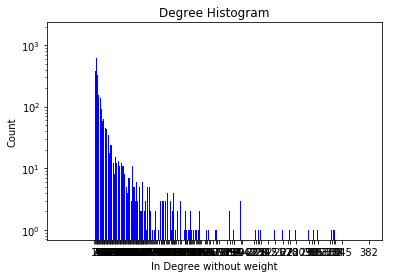

In [7]:
degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("In Degree without weight")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
ax.set_yscale('log')
ax.set_xlim(right=400)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
plt.axis('off')
plt.show()

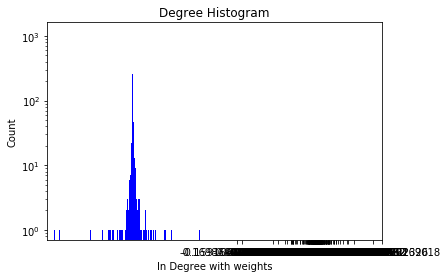

In [17]:
#in_degree_list_weight
degree_sequence_in_weighted = [node[1] for node in in_degree_list_weight]

degreeCount = collections.Counter(degree_sequence_in_weighted)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.0010, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("In Degree with weights")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
ax.set_yscale('log')
#ax.set_xlim(right=400)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
plt.axis('off')
plt.show()


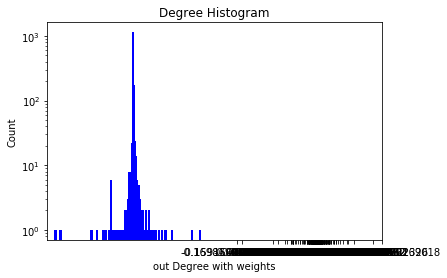

In [20]:
#out_degree_list_weight
degree_sequence_out_weighted = [int(node[1]*100000) for node in out_degree_list_weight]

degreeCount = collections.Counter(degree_sequence_in_weighted)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.005, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("out Degree with weights")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
ax.set_yscale('log')
#ax.set_xlim(right=400)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
plt.axis('off')
plt.show()

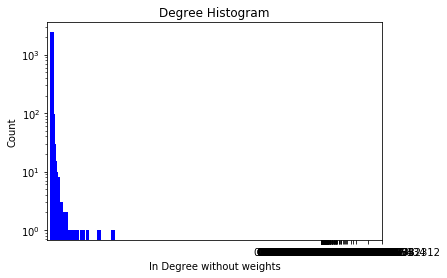

In [23]:
#in_degree_list_not_weight
degree_sequence_in = [node[1] for node in in_degree_list]

degreeCount = collections.Counter(degree_sequence_in)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.005, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("In Degree without weights")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
ax.set_yscale('log')
#ax.set_xlim(right=5000)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
plt.axis('off')
plt.show()


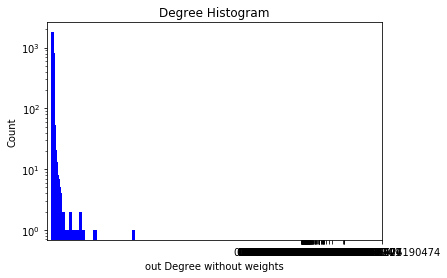

In [25]:
#out_degree_list_not_weight
degree_sequence_out = [node[1] for node in out_degree_list]

degreeCount = collections.Counter(degree_sequence_out)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.005, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("out Degree without weights")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
ax.set_yscale('log')
#ax.set_xlim(right=5000)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
plt.axis('off')
plt.show()

In [26]:
in_not_weight = sorted(in_degree_list, key=lambda tup: tup[0], reverse=True)
out_not_weight = sorted(out_degree_list, key=lambda tup: tup[0], reverse=True)
in_weight = sorted(in_degree_list_weight, key=lambda tup: tup[0], reverse=True)
out_weight = sorted(out_degree_list_weight, key=lambda tup: tup[0], reverse=True)

In [27]:
to_data_frame = list()
for i in range(len(in_not_weight)):
    to_data_frame.append((in_not_weight[i][0], in_not_weight[i][1], out_not_weight[i][1], in_weight[i][1], out_weight[i][1]))
print(to_data_frame[:10])


[(6005, 0.00017006802721088434, 0.0, 0.0, 0.00017003910899506886), (6004, 0.00017006802721088434, 0.0, 0.0, 0.00017003910899506886), (6003, 0.00017006802721088434, 0.0, 0.0, 0.00017003910899506886), (6002, 0.00017006802721088434, 0.0, 0.0, 0.00017003910899506886), (6000, 0.0, 0.00017006802721088434, 0.00017003910899506886, 0.0), (5999, 0.00017006802721088434, 0.00017006802721088434, 0.0013603128719605509, 0.00017003910899506886), (5998, 0.00017006802721088434, 0.0, 0.0, 0.00017003910899506886), (5997, 0.00017006802721088434, 0.0, 0.0, 0.00017003910899506886), (5996, 0.00017006802721088434, 0.00017006802721088434, 0.0005101173269852066, 0.0005101173269852066), (5995, 0.00017006802721088434, 0.00017006802721088434, 0.00017003910899506886, 0.00017003910899506886)]


In [28]:
dataframe = pd.DataFrame(to_data_frame)
dataframe

,0,1,2,3,4
0,6005,0.000170,0.000000,0.000000,0.000170
1,6004,0.000170,0.000000,0.000000,0.000170
2,6003,0.000170,0.000000,0.000000,0.000170
3,6002,0.000170,0.000000,0.000000,0.000170
4,6000,0.000000,0.000170,0.000170,0.000000
...,...,...,...,...,...
5876,5,0.000510,0.000510,0.001190,0.001190
5877,4,0.009184,0.010714,0.029757,0.028567
5878,3,0.003571,0.000000,0.000000,-0.001020
5879,2,0.006973,0.007653,0.024316,0.020915
